In [3]:
!pip install gdown
!pip install opencv-python tensorflow numpy pandas scikit-learn matplotlib rasterio





In [5]:
import os
import gdown
from glob import glob
import zipfile
import shutil
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from tqdm import tqdm
import re
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [7]:



BASE_URL = 'https://drive.google.com/uc?id={}'
BASE_PATH = os.path.abspath("C:/content")
COMPRESSED_DIR = os.path.join(BASE_PATH, "compressed")

REGIONS = {
    'South_America': '1hnBUmYkvFYohTf9hTnKiyp2MXVevglK7',
    'Oceania': '1xHYTICHKU0u3-kIrq-pM9k0YaeQt60Bt',
    'North_America1': '1BXRGldTdGGNeWDOFqNnmiNPuPQjweB2M',
    'North_America2': '1zW_pEIggJ5Li7uQX9XKMfHkcgL3kiUoi',
    'Africa': '1Ng3JwsjJPApshk8lJdGcsNHI52NaEMDX',
    'Europe': '1vANGtfuEdn0ZnILA6BYXW1_7jt8CU0gA',
    'Asia1': '1xgOQkeQIswq3hLBhNzuNPTtsL4ZavuC3',
    'Asia2': '1w_wv0_QZhnH9jO1ygJg6ssTrXupIbTHp',
    'Asia3': '1heefSuPsnLZkNSJ2jTa4M-jGWo_9nAri',
    'Asia4': '1lyR6y6u8tSozfv3AQJ1PuUcdR0BU9yUk',
    'Asia5': '1Y1UysFrZ8AiugKvDpWI3nHcjo7-CQ4Dp',
}

SUBSET_SAMPLES = {
    'samples': '1gwQdhXrxCybcO16vem09DfW5fPadAA_p',
}
def download_file(file_id, output):
    """
    Download a file from Google Drive by its ID.
    Args:
        file_id (str): Google Drive file ID.
        output (str): Output path for the downloaded file.
    """
    url = BASE_URL.format(file_id)
    print(f"Downloading from Google Drive: {output}")
    gdown.download(url, output, quiet=False, fuzzy=True)


def download_regions(region_list, output_dir=COMPRESSED_DIR, subset=False):
    """
    Download specified datasets or subset samples.
    Args:
        region_list (list): List of regions to download.
        output_dir (str): Output directory.
        subset (bool): If True, download only the subset samples.zip.
    Returns:
        List of downloaded file paths or path to subset zip.
    """
    os.makedirs(output_dir, exist_ok=True)

    if subset:
        zip_file_name = 'samples.zip'
        output = os.path.join(BASE_PATH, zip_file_name)
        print("Downloading subset samples...")
        download_file(SUBSET_SAMPLES['samples'], output)
        return output
    else:
        downloaded_files = []
        for region in region_list:
            if region not in REGIONS:
                print(f"Unknown region {region}. Skipped.")
                continue
            zip_file_name = f'{region}.zip'
            output = os.path.join(output_dir, zip_file_name)
            print(f"=== Downloading region: {region} ===")
            download_file(REGIONS[region], output)
            downloaded_files.append(output)
        return downloaded_files



In [8]:


BASE_PATH = os.path.abspath("C:/content")
COMPRESSED_DIR = os.path.join(BASE_PATH, "compressed")
IMAGES_DIR = os.path.join(BASE_PATH, "images")
MASKS_DIR = os.path.join(BASE_PATH, "masks")

# Function to unzip either the full dataset or the subset samples
# Args:
#   full_dataset (bool): If True, unzip full dataset, else subset
#   samples_zip_path (str): Path to samples.zip
#   compressed_dir (str): Path to downloaded continent zips
#   output_dir (str): Final output directory
# Usage: unzip_dataset(full_dataset=True) or unzip_dataset(full_dataset=False)
def unzip_dataset(full_dataset=True,
                  samples_zip_path=os.path.join(BASE_PATH, "samples.zip"),
                  compressed_dir=COMPRESSED_DIR,
                  output_dir=BASE_PATH):
    if full_dataset:
        print('Unzipping Full Dataset...')
        # Create fixed directories for images and masks
        patches_output_dir = os.path.join(IMAGES_DIR, 'patches')
        masks_output_dir = os.path.join(MASKS_DIR, 'patches')
        voting_output_dir = os.path.join(MASKS_DIR, 'voting')
        intersection_output_dir = os.path.join(MASKS_DIR, 'intersection')
        for d in [patches_output_dir, masks_output_dir, voting_output_dir, intersection_output_dir]:
            os.makedirs(d, exist_ok=True)
        zips_continents = glob(os.path.join(compressed_dir, '*.zip'))
        tmp_dir = os.path.join(output_dir, 'tmp')
        tmp_derivates = os.path.join(output_dir, 'tmp_derivates')
        print(f'Unzip images to {patches_output_dir}')
        print(f'Unzip masks to {masks_output_dir}')
        total_files = 0
        for zip_continent in zips_continents:
            print(f'Unzipping: {zip_continent}')
            os.makedirs(tmp_dir, exist_ok=True)
            with zipfile.ZipFile(zip_continent, 'r') as zip_ref:
                print(f'Num zipped files: {len(zip_ref.namelist())}')
                zip_ref.extractall(tmp_dir)
            patches_zips = glob(os.path.join(tmp_dir, '*.zip'))
            print(f'Num. of zips unpacked: {len(patches_zips)}')
            print('Unzipping patches...')
            num_files = 0
            for patches_zip in patches_zips:
                output_dir_zip = patches_output_dir
                if patches_zip.endswith('masks_derivates.zip'):
                    with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
                        zip_ref.extractall(tmp_derivates)
                        num_files += len(zip_ref.namelist())
                    derivate_patches = glob(os.path.join(tmp_derivates, '*.tif'))
                    for derivate_patch in derivate_patches:
                        if '_voting_' in derivate_patch.lower():
                            shutil.move(derivate_patch, derivate_patch.replace(tmp_derivates, voting_output_dir))
                        elif '_intersection_' in derivate_patch.lower():
                            shutil.move(derivate_patch, derivate_patch.replace(tmp_derivates, intersection_output_dir))
                    shutil.rmtree(tmp_derivates)
                    continue
                if patches_zip.endswith('masks.zip'):
                    output_dir_zip = masks_output_dir
                with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
                    zip_ref.extractall(output_dir_zip)
                    num_files += len(zip_ref.namelist())
            total_files += num_files
            print(f'Zip: {zip_continent} - Patches: {num_files}')
            shutil.rmtree(tmp_dir)
        print(f'Total files unzipped: {total_files}')
        print('Full Dataset Ready!')
    else:
        print("Unzipping subset samples...")
        with tempfile.TemporaryDirectory() as tmpdirname:
            with zipfile.ZipFile(samples_zip_path, 'r') as zip_ref:
                zip_ref.extractall(tmpdirname)
            images_path = IMAGES_DIR
            masks_path = MASKS_DIR
            manual_annotations_path = os.path.join(BASE_PATH, 'manual_annotations', 'patches')
            for d in [images_path, masks_path, manual_annotations_path]:
                os.makedirs(d, exist_ok=True)
            image_zip = os.path.join(tmpdirname, 'samples', 'images', 'patches.zip')
            with zipfile.ZipFile(image_zip, 'r') as zip_ref:
                zip_ref.extractall(images_path)
            masks_zips = glob(os.path.join(tmpdirname, 'samples', 'masks', '*.zip'))
            for mask_zip in masks_zips:
                with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
                    zip_ref.extractall(masks_path)
            masks = glob(os.path.join(masks_path, 'patches', '*_GOLI_v2_*.tif'))
            for mask in masks:
                mask_name = os.path.basename(mask)
                os.rename(
                    os.path.join(masks_path, 'patches', mask_name),
                    os.path.join(masks_path, 'patches', mask_name.replace('GOLI_v2', 'Kumar-Roy'))
                )
            manual_annotations_zips = glob(os.path.join(tmpdirname, 'samples', 'manual_annotations', '*.zip'))
            for manual_ann_zip in manual_annotations_zips:
                with zipfile.ZipFile(manual_ann_zip, 'r') as zip_ref:
                    zip_ref.extractall(manual_annotations_path)
        print("Subset unzipped successfully.")


In [ ]:
"""
Returns two lists:
- images_list: paths to images with at least NUM_PIXELS fire pixels
- masks_list: paths to corresponding masks
"""

# Set paths and parameters



MASK_PATH = r"C:/content/masks/patches"
IMAGE_PATH = r"C:/content/images/patches"
MASK_ALGORITHM = "Kumar-Roy"  # change if needed
NUM_PIXELS = 20

# Load a mask as a numpy array
def get_mask_arr(path):
    """
    Load a mask as a numpy array.
    Args:
        path (str): Path to mask file.
    Returns:
        np.ndarray: Mask array.
    """
    with rasterio.open(path) as src:
        img = src.read().transpose((1, 2, 0))
        seg = np.array(img, dtype=int)
        return seg[:, :, 0]

# Find images and masks with at least num_pixels fire pixels
def find_fire_images_and_masks(mask_path=MASK_PATH, 
                               image_path=IMAGE_PATH,
                               num_pixels=NUM_PIXELS, 
                               algo=MASK_ALGORITHM,
                               manual=False):
    """
    Returns two lists:
    - images_list: paths to image files
    - masks_list: paths to mask files
    
    Args:
        mask_path (str): Path to masks directory.
        image_path (str): Path to images directory.
        num_pixels (int): Minimum number of fire pixels required.
        algo (str): Algorithm name used in mask filenames (ignored if manual=True).
        manual (bool): If True, search in manual_annotations/patches.
    """
    if manual:
        BASE_PATH = r"C:\content"   
        mask_path = os.path.join(BASE_PATH, "manual_annotations", "patches", "manual_annotations_patches")
        mask_path = os.path.normpath(mask_path)  
        masks_files = glob(os.path.join(mask_path, "*.tif"))
        image_path = os.path.normpath(
        os.path.join("c:/content", "manual_annotations", "patches", "landsat_patches"))

    
    else:
        # Algorithm-generated masks follow the naming convention with algo
        masks_files = glob(os.path.join(mask_path, f"*{algo}*.tif"))
    
    images_list, masks_list = [], []
    for mask_file in masks_files:
        mask = get_mask_arr(mask_file)
        count = (mask > 0).sum()
        
        # Keep only masks with enough fire pixels
        if count > num_pixels:
            mask_name = os.path.basename(mask_file)
            
            if manual:
                # Remove version tags like "_v1_", "_v2_", etc. from mask filename
                image_name = re.sub(r"_v\d+_", "_", mask_name)
            else:
                # Algorithmic masks need the algo tag removed to match image names
                image_name = mask_name.replace(f"_{algo}_", "_")
            
            image_file = os.path.join(image_path, image_name)
            if os.path.exists(image_file):
                images_list.append(image_file)
                masks_list.append(mask_file)
  
    return images_list, masks_list



In [33]:


# Normalisation max Landsat pixel value (ex: 65535 pour 16-bit)
MAX_PIXEL_VALUE = 65535.0

def get_img_762bands(path):
    """
    Load image with bands 7, 6, 2 and normalize.
    Args:
        path (str): Path to image file.
    Returns:
        np.ndarray: Normalized image array.
    """
    img = rasterio.open(path).read((7,6,2)).transpose((1, 2, 0))
    img = np.float32(img)/MAX_PIXEL_VALUE
    return img

def get_mask_arr(path):
    """
    Load mask as float32 numpy array.
    Args:
        path (str): Path to mask file.
    Returns:
        np.ndarray: Mask array.
    """
    img = rasterio.open(path).read().transpose((1, 2, 0))
    seg = np.float32(img)
    return seg

def load_all_images_and_masks(images_path_list, masks_path_list, size=(256, 256)):
    """
    Load all images and masks into numpy arrays with progress bar.
    Args:
        images_path_list (list): List of image paths.
        masks_path_list (list): List of mask paths.
        size (tuple): Target size.
    Returns:
        X, y: Arrays of images and masks.
    """
    X = []
    y = []
    fopen_image = get_img_762bands
    fopen_mask = get_mask_arr
    for img_path, mask_path in tqdm(zip(images_path_list, masks_path_list),
                                    total=len(images_path_list),
                                    desc="Loading images and masks"):
        try:
            img = fopen_image(img_path)
            mask = fopen_mask(mask_path)
            X.append(img)
            y.append(mask)
        except Exception as e:
            print(f"[WARNING] Could not load {img_path} or {mask_path} | Error: {e}")
            
    return np.array(X), np.array(y)


In [ ]:



# -----------------------------
# Double Convolution Block for U-Net encoder/decoder
# -----------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


# -----------------------------
# Attention Gate
# -----------------------------
class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


# -----------------------------
# Attention U-Net
# -----------------------------
class AttentionUNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=1):
        """
        Attention U-Net model for segmentation

        Args:
            img_ch (int): Number of input image channels (default: 3)
            output_ch (int): Number of output channels (default: 1)
        """
        super().__init__()

        # Encoder
        self.conv1 = ConvBlock(img_ch, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = ConvBlock(512, 1024)

        # Attention + Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(512, 512, 256)
        self.up_conv4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(256, 256, 128)
        self.up_conv3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(128, 128, 64)
        self.up_conv2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(64, 64, 32)
        self.up_conv1 = ConvBlock(128, 64)

        # Final conv
        self.out_conv = nn.Conv2d(64, output_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        p1 = self.pool1(x1)

        x2 = self.conv2(p1)
        p2 = self.pool2(x2)

        x3 = self.conv3(p2)
        p3 = self.pool3(x3)

        x4 = self.conv4(p3)
        p4 = self.pool4(x4)

        x5 = self.conv5(p4)

        d4 = self.up4(x5)
        x4 = self.att4(x4, d4)
        d4 = torch.cat((x4, d4), dim=1)
        d4 = self.up_conv4(d4)

        d3 = self.up3(d4)
        x3 = self.att3(x3, d3)
        d3 = torch.cat((x3, d3), dim=1)
        d3 = self.up_conv3(d3)

        d2 = self.up2(d3)
        x2 = self.att2(x2, d2)
        d2 = torch.cat((x2, d2), dim=1)
        d2 = self.up_conv2(d2)

        d1 = self.up1(d2)
        x1 = self.att1(x1, d1)
        d1 = torch.cat((x1, d1), dim=1)
        d1 = self.up_conv1(d1)

        out = self.out_conv(d1)
        out = F.interpolate(out, size=(256, 256), mode="bilinear", align_corners=False)
        return out





In [12]:



# -----------------------------
# Clear GPU cache
# -----------------------------
torch.cuda.empty_cache()


# -----------------------------
# Create the model and set device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(img_ch=3, output_ch=1).to(device)
device


device(type='cuda')

In [13]:


# -----------------------------
# Dice Loss for binary segmentation
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_true_f = y_true.view(-1)
        y_pred_f = y_pred.view(-1)
        intersection = (y_true_f * y_pred_f).sum()
        dice = (2. * intersection + self.smooth) / (y_true_f.sum() + y_pred_f.sum() + self.smooth)
        return 1 - dice   # Return the loss, so 1 - Dice
        

# -----------------------------
# Focal Loss for binary segmentation
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.clamp(1e-7, 1 - 1e-7)

        bce = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
        pt = torch.where(y_true == 1, y_pred, 1 - y_pred)
        focal_term = self.alpha * (1 - pt) ** self.gamma
        loss = focal_term * bce

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


# -----------------------------
# Combined Focal and Dice Loss for segmentation
# -----------------------------
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2., lambda_dice=1.0, lambda_focal=1.0):
        super().__init__()
        self.focal = FocalLoss(gamma=gamma, alpha=alpha)
        self.dice = DiceLoss()
        self.lambda_dice = lambda_dice
        self.lambda_focal = lambda_focal

    def forward(self, y_pred, y_true):
        loss_focal = self.focal(y_pred, y_true)
        loss_dice = self.dice(y_pred, y_true)
        return self.lambda_focal * loss_focal + self.lambda_dice * loss_dice





In [14]:


def cleanup_dataset(
    image_path='images/patches',
    mask_path='masks/patches',
    compressed_path='compressed'
):
    """
    Delete all files in:
    - images/patches
    - masks/patches
    - compressed
    
    And recreate empty folders to avoid errors later.
    """
    removed = 0
    for folder in [image_path, mask_path, compressed_path]:
        if os.path.exists(folder):
            for f in os.listdir(folder):
                file_path = os.path.join(folder, f)
                try:
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                        removed += 1
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                        removed += 1
                except Exception as e:
                    print(f"Could not delete {file_path}: {e}")
        else:
            os.makedirs(folder, exist_ok=True)

    print(f"Cleanup complete. {removed} files deleted.")


In [ ]:



EPOCHS = 10
BATCH_SIZE = 8

# Custom Dataset for fire images and masks
class FireDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img.float(), mask.float()

# Dice coefficient metric for segmentation
def dice_coef(y_true, y_pred, smooth=1.0):
    y_pred = (torch.sigmoid(y_pred) > 0.5).float()  # binarization
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

# Main training loop
# Trains the model for each region, splits data, and cleans up after each region
# Uses FocalDiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
criterion = FocalDiceLoss(alpha=0.75, gamma=2., lambda_dice=1.0, lambda_focal=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
transform = transforms.Compose([
    transforms.ToTensor(),
])
regions = [
    "South_America",
    # "Asia2", "Asia3", "Asia4",
    # "North_America1", "North_America2"
]
cleanup_dataset(
    image_path="c:/content/images/patches",
    mask_path="c:/content/masks/patches",
    compressed_path="c:/content/compressed"
) 
for region in regions:
    print(f"\n === Processing {region} ===")
    download_regions([region], output_dir="c:/content/compressed")
   
   
    unzip_dataset(full_dataset=True,
                compressed_dir="c:/content/compressed",
              output_dir="c:/content") 
    
    image_paths, masks_paths = find_fire_images_and_masks(

    manual=False  ,
)
    print(f"Images found: {len(image_paths)}")
    print(f"Masks found: {len(masks_paths)}")

    X, y = load_all_images_and_masks(image_paths, masks_paths, size=(256, 256))
    dataset = FireDataset(X, y, transform=transform)
    test_size = int(0.05 * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    model.to(device)
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_dice = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            dice = dice_coef(masks, outputs)
            running_dice += dice.item()
        avg_loss = running_loss / len(train_loader)
        avg_dice = running_dice / len(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f}")
    del dataset, train_loader, X, y
    torch.cuda.empty_cache()
    cleanup_dataset(
        image_path="c:/content/images/patches",
        mask_path="c:/content/masks/patches",
        compressed_path="c:/content/compressed"
    )


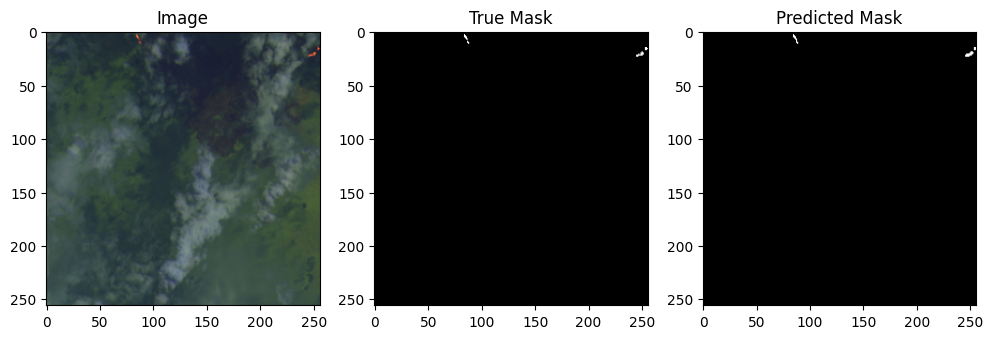

In [99]:


# -----------------------------
# Test the model on a batch
# -----------------------------
model.to(device)
model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

# -----------------------------
# Visualization
# -----------------------------
idx = np.random.randint(0, images.shape[0])
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(images[idx].cpu().permute(1, 2, 0)[..., :3])  # 3 channels
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(masks[idx].cpu().squeeze(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(preds[idx].cpu().squeeze(), cmap="gray")
plt.show()


In [ ]:
# === 1. Download the subset sample ===
samples_zip = download_regions(region_list=None, subset=True, output_dir=COMPRESSED_DIR)

# === 2. Unzip ===
unzip_dataset(full_dataset=False, samples_zip_path=samples_zip)

# === 3. Load filtered images + masks ===
image_paths, mask_paths = find_fire_images_and_masks(
    image_path=os.path.join(IMAGES_DIR, "patches"),
    num_pixels=10,
    manual=True   
)
transform = transforms.Compose([
    transforms.ToTensor(),
])
print(f"Images found: {len(image_paths)}")
print(f"Masks found: {len(mask_paths)}")
X, y = load_all_images_and_masks(image_paths, mask_paths, size=(256, 256))
dataset = FireDataset(X, y, transform=transform)
test_size = int(1 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Downloading...
From (original): https://drive.google.com/uc?id=1gwQdhXrxCybcO16vem09DfW5fPadAA_p
From (redirected): https://drive.google.com/uc?id=1gwQdhXrxCybcO16vem09DfW5fPadAA_p&confirm=t&uuid=07c513d3-5fff-4b20-a9b1-9f07c6090217
To: C:\content\samples.zip
100%|██████████| 242M/242M [00:10<00:00, 22.5MB/s] 


Unzipping subset samples...
Subset unzipped successfully.
['c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1GT_226074_20200921_20200921_01_RT_p00811.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1GT_226074_20200921_20200921_01_RT_p00812.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1TP_025033_20200921_20200921_01_RT_p00170.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1TP_046031_20200908_20200908_01_RT_p00583.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1TP_046031_20200908_20200908_01_RT_p00584.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1TP_046031_20200908_20200908_01_RT_p00603.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1TP_046031_20200908_20200908_01_RT_p00604.tif', 'c:\\content\\manual_annotations\\patches\\landsat_patches\\LC08_L1TP_046031_20200908_20200908_01_RT_p00613.tif', 'c:\\content\\manual_annotati

Loading images and masks: 100%|██████████| 44/44 [00:01<00:00, 35.31it/s]


In [ ]:
# Evaluate the model on the test_loader
def evaluate_model(model, test_loader, device):
    """
    Evaluate model on test data.
    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Test data loader.
        device (torch.device): Device to use.
    Returns:
        avg_loss, avg_dice: Average loss and dice coefficient.
    """
    model.eval()
    total_dice = 0.0
    total_loss = 0.0
    criterion = FocalDiceLoss(alpha=0.75, gamma=2., lambda_dice=1.0, lambda_focal=1.0)
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            outputs = torch.sigmoid(outputs)
            dice = dice_coef(outputs, masks)
            total_loss += loss.item()
            total_dice += dice
    avg_loss = total_loss / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Dice Coefficient: {avg_dice:.4f}")
    return avg_loss, avg_dice

evaluate_model(model, test_loader, device)

In [ ]:
save_path = "attention_unet_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")

NameError: name 'torch' is not defined

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize the model with the same args used during training
model = AttentionUNet().to(device)

# load checkpoint (assumes file is in the same directory)
checkpoint = torch.load("attention_unet_weights.pth", map_location=device)

# if it’s just a state_dict
if isinstance(checkpoint, dict) and "state_dict" not in checkpoint:
    model.load_state_dict(checkpoint)
else:  # if it’s a checkpoint with "state_dict"
    model.load_state_dict(checkpoint["state_dict"])

model.eval()

print("✅ Model loaded and ready for inference")

✅ Model loaded and ready for inference
